In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [2]:
df_low = pd.read_csv('tail_JSD_novelty_regression.tsv', sep = '\t')
df_high = pd.read_csv('top_JSD_novelty_regression.tsv', sep = '\t')

In [3]:
len(df_low)

16665

In [4]:
df_low = df_low.replace([np.inf, -np.inf], np.nan)
df_low = df_low.dropna(how = 'any')
df_high= df_high.replace([np.inf, -np.inf], np.nan)
df_high = df_high.dropna(how = 'any')


In [5]:
len(df_high)

16658

In [9]:
df_high.head()

,index,Author,Bookmarks,ChapterIndex,Chapters,Comments,Hits,Kudos,Text,Words,...,Fandom_tolkien,Fandom_shakespare,Fandom_hetalia,Fandom_attack_on_titan,Fandom_ms_paint_adventures,Fandom_marvel,Fandom_sailor_moon,Fandom_one_direction,Fandom_sherlock,History
0,172709,Kila9Nishika,0.000000,1.0,2,0,7.000000,1.500000,This is an emergency.\xc2\xa0 Repeat.\xc2\xa0 ...,2277.000000,...,0,0,0,0,0,0,0,0,0,3298.0
1,181007,sylvanawood,0.272727,30.0,99,0,29.767677,1.262626,\nHogwarts School of Witchcraft and WizardrySt...,345.939394,...,0,0,0,0,0,0,0,0,0,3086.0
2,178953,MissE,3.000000,0.0,1,1,562.000000,22.000000,"\nIt wasn\'t his fault. There was, after all, ...",597.000000,...,0,0,0,0,0,0,0,0,0,2868.0
3,65719,Nemainofthewater,3.600000,5.0,15,0,337.866667,11.200000,"Thor sat in the mortal infirmary, next to the ...",824.466667,...,0,0,0,0,0,0,0,0,0,1641.0
4,65646,Nemainofthewater,3.600000,2.0,15,0,337.866667,11.200000,"\xe2\x80\x9cI\xe2\x80\x99m sorry sir, you must...",824.466667,...,0,0,0,0,0,0,0,0,0,1641.0


In [13]:
df_high.columns.values

array(['index', 'Author', 'Bookmarks', 'ChapterIndex', 'Chapters',
       'Comments', 'Hits', 'Kudos', 'Text', 'Words', 'Dist',
       'Topic_novelty', 'Freq_relationship', 'Topic_entropy', 'Sentiment',
       'Category_F_F', 'Category_F_M', 'Category_Gen', 'Category_M_M',
       'Category_Multi', 'Category_Other', 'Category_Unknown',
       'ArchiveWarnings_underage', 'ArchiveWarnings_death',
       'ArchiveWarnings_choose_no', 'ArchiveWarnings_no_apply',
       'ArchiveWarnings_violence', 'ArchiveWarnings_noncon', 'Rating_E',
       'Rating_G', 'Rating_M', 'Rating_N', 'Rating_T',
       'Fandom_harry_potter', 'Fandom_dcu', 'Fandom_doctor_who',
       'Fandom_star_wars', 'Fandom_arthurian', 'Fandom_supernatural',
       'Fandom_haikyuu', 'Fandom_kuroko_no_basuke',
       'Fandom_hamilton_miranda', 'Fandom_dragon_age',
       'Fandom_the_walking_dead', 'Fandom_buffy', 'Fandom_les_miserables',
       'Fandom_naruto', 'Fandom_tolkien', 'Fandom_shakespare',
       'Fandom_hetalia', 'Fando

### Logistic

In [10]:
def run_logit(df, field):
    df['Intercept'] = 1.0
    df['binary'] = df[field].apply(lambda x: 1 if x != 0.0 else 0)
    logit_model = sm.Logit(df['binary'], df[[ 'Topic_entropy','Sentiment',\
                'ArchiveWarnings_underage', 'ArchiveWarnings_death',\
                'ArchiveWarnings_no_apply', 'ArchiveWarnings_violence',\
                'ArchiveWarnings_noncon','Rating_E','Rating_G','Rating_M',\
                'Rating_T','Category_F_F','Category_F_M','Category_Gen','Category_M_M',\
                'Category_Multi','Category_Other','Freq_relationship',\
                'ChapterIndex','Chapters','Words', \
       'Fandom_harry_potter','Fandom_dcu','Fandom_doctor_who', \
       'Fandom_star_wars','Fandom_arthurian','Fandom_supernatural',\
       'Fandom_haikyuu','Fandom_kuroko_no_basuke',\
       'Fandom_hamilton_miranda','Fandom_dragon_age',\
       'Fandom_the_walking_dead','Fandom_buffy','Fandom_les_miserables',\
       'Fandom_naruto','Fandom_tolkien','Fandom_shakespare',\
       'Fandom_hetalia','Fandom_attack_on_titan',\
       'Fandom_ms_paint_adventures','Fandom_marvel',\
       'Fandom_sailor_moon','Fandom_sherlock',\
        'Intercept']]).fit(method='bfgs')
    pred = logit_model.predict()
    df['nonzero_prob'] = pred
    return df

### OLS

In [11]:

def run_ols(df, field):
    df = run_logit(df, field)
    df = df[df[field] != 0]
    df['Kudos'] = np.log(df['Kudos'])
    df['Hits'] = np.log(df['Hits'])
    df['Comments'] = np.log(df['Comments'])
    df['Bookmarks'] = np.log(df['Bookmarks'])
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(how = 'any')
    model = ols( field + " ~ + Topic_entropy + Sentiment + \
                ArchiveWarnings_underage + ArchiveWarnings_death + \
                ArchiveWarnings_no_apply + ArchiveWarnings_violence + \
                ArchiveWarnings_noncon + Rating_E + Rating_G + Rating_M + \
                Rating_T + Category_F_F + Category_F_M + Category_Gen + Category_M_M + \
                Category_Multi + Category_Other + Freq_relationship + \
                ChapterIndex + Chapters + Words+ \
        Fandom_harry_potter + Fandom_dcu + Fandom_doctor_who + \
       Fandom_star_wars + Fandom_arthurian + Fandom_supernatural +\
       Fandom_haikyuu + Fandom_kuroko_no_basuke + \
       Fandom_hamilton_miranda + Fandom_dragon_age +\
       Fandom_the_walking_dead + Fandom_buffy + Fandom_les_miserables +\
       Fandom_naruto + Fandom_tolkien + Fandom_shakespare + \
       Fandom_hetalia + Fandom_attack_on_titan +\
       Fandom_ms_paint_adventures + Fandom_marvel +\
       Fandom_sailor_moon + Fandom_sherlock + nonzero_prob", data = df).fit()
    return model

### Plot coefficients

In [12]:
kudos_model_low = run_ols(df_low, 'Kudos')
kudos_coef_low = np.asarray(list(kudos_model_low.params)[1:-1])
kudos_err_low = list(kudos_model_low.bse)[1:-1]

kudos_model_high = run_ols(df_high, 'Kudos')
kudos_coef_high = np.asarray(list(kudos_model_high.params)[1:-1])
kudos_err_high = list(kudos_model_high.bse)[1:-1]

KeyError: "['Term_novelty'] not in index"

In [87]:
hits_model_low = run_ols(df_low, 'Hits')
hits_coef_low = np.asarray(list(hits_model_low.params)[1:-1])
hits_err_low = list(hits_model_low.bse)[1:-1]

hits_model_high = run_ols(df_high, 'Hits')
hits_coef_high = np.asarray(list(hits_model_high.params)[1:-1])
hits_err_high = list(hits_model_high.bse)[1:-1]

/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/envs/python36/lib/python3.6/site-packages/s

         Current function value: 0.086243
         Iterations: 35
         Function evaluations: 59
         Gradient evaluations: 54


/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/envs/python36/lib/python3.6/site-packages/s

         Current function value: 0.091548
         Iterations: 35
         Function evaluations: 57
         Gradient evaluations: 52


In [88]:
comments_model_low = run_ols(df_low, 'Comments')
comments_coef_low = np.asarray(list(comments_model_low.params)[1:-1])
comments_err_low = list(comments_model_low.bse)[1:-1]

comments_model_high = run_ols(df_high, 'Comments')
comments_coef_high = np.asarray(list(comments_model_high.params)[1:-1])
comments_err_high = list(comments_model_high.bse)[1:-1]

/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/envs/python36/lib/python3.6/site-packages/s

         Current function value: 0.641681
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 41


/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/envs/python36/lib/python3.6/site-packages/s

         Current function value: 0.642420
         Iterations: 35
         Function evaluations: 52
         Gradient evaluations: 41


In [89]:
bookmarks_model_low = run_ols(df_low, 'Bookmarks')
bookmarks_coef_low = np.asarray(list(bookmarks_model_low.params)[1:-1])
bookmarks_err_low = list(bookmarks_model_low.bse)[1:-1]

bookmarks_model_high = run_ols(df_high, 'Bookmarks')
bookmarks_coef_high = np.asarray(list(bookmarks_model_high.params)[1:-1])
bookmarks_err_high = list(bookmarks_model_high.bse)[1:-1]

/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/envs/python36/lib/python3.6/site-packages/s

         Current function value: 0.381512
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 40


/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/envs/python36/lib/python3.6/site-packages/s

         Current function value: 0.490054
         Iterations: 35
         Function evaluations: 48
         Gradient evaluations: 40


In [90]:
ylabels =[
               'Topic_entropy', 'Sentiment' , \
                'ArchiveWarnings(underage)', 'ArchiveWarnings(death)', \
                'ArchiveWarnings(no apply)', 'ArchiveWarnings(violence)', \
                'ArchiveWarnings(nonconsensual)' , 'Rating E' , 'Rating G' , 'Rating M' , \
                'Rating T' , 'Category F/F' , 'Category F/M' , 'Category Gen' , 'Category M/M' , \
                'Category Multi' , 'Category Other' , 'Frequent relationship' , \
                'ChapterIndex' , 'Chapters' , 'Words', \
        'Fandom harry potter' , 'Fandom dcu' , 'Fandom doctor who' , \
       'Fandom star wars' , 'Fandom arthurian' , 'Fandom supernatural' ,\
       'Fandom haikyuu' , 'Fandom kuroko no basuke' , \
       'Fandom hamilton miranda' , 'Fandom dragon age' ,\
       'Fandom the walking dead' , 'Fandom buffy' , 'Fandom les miserables' ,\
       'Fandom naruto' , 'Fandom tolkien' , 'Fandom shakespare' , \
       'Fandom hetalia' , 'Fandom attack on titan' ,\
       'Fandom ms paint adventures' , 'Fandom marvel' ,\
       'Fandom sailor moon' , 'Fandom sherlock'][::-1]

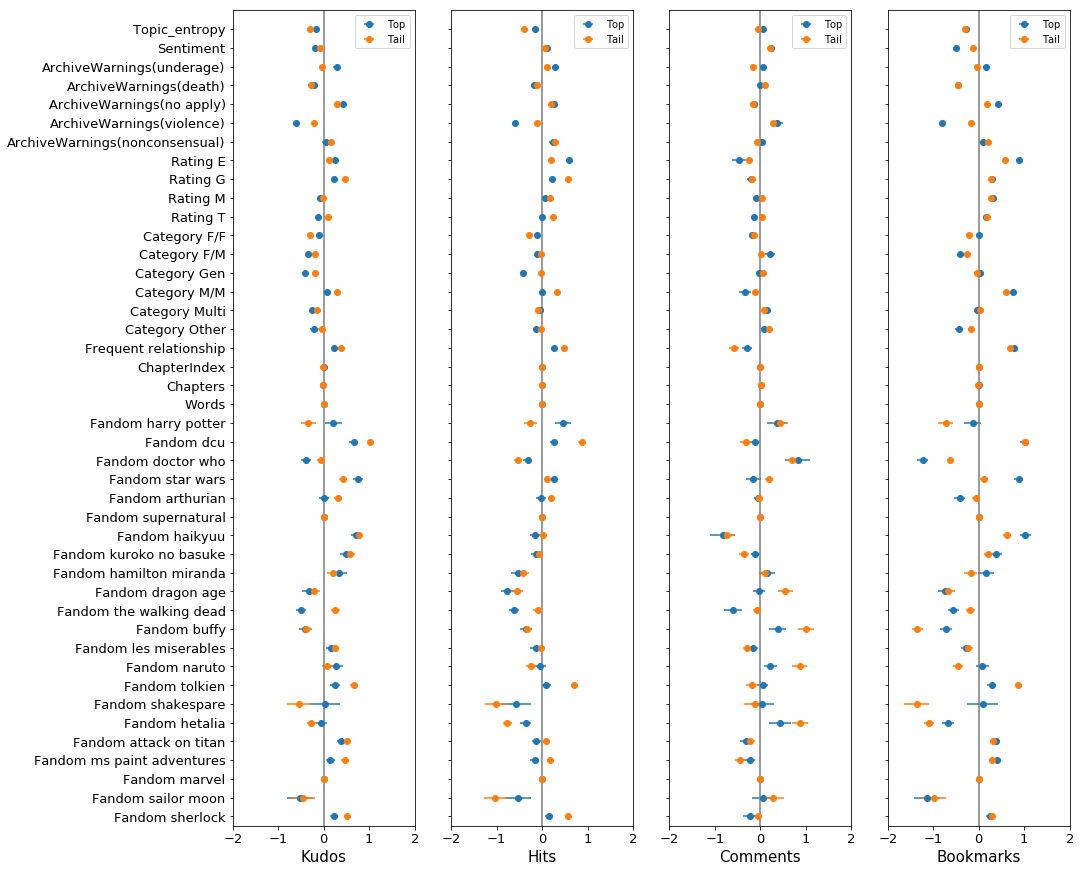

In [128]:
fig, ax = plt.subplots(1,4,figsize = (15,15))
plot_ax(ax=ax[0], coef=kudos_coef_high, err=kudos_err_high, top_tail_option='Top', xlabel='Kudos', ylabel_flag=True)
plot_ax(ax=ax[0], coef=kudos_coef_low, err=kudos_err_low, top_tail_option='Tail', ylabel_flag=True)
,
plot_ax(ax=ax[1], coef=hits_coef_high, err=hits_err_high, xlabel='Hits', top_tail_option='Top')
plot_ax(ax=ax[1], coef=hits_coef_low, err=hits_err_low, top_tail_option='Tail')

plot_ax(ax=ax[2], coef=comments_coef_high, err=comments_err_high, xlabel='Comments', ylabel_flag=False, top_tail_option='Top')
plot_ax(ax=ax[2], coef=comments_coef_low, err=comments_err_low, top_tail_option='Tail')

plot_ax(ax=ax[3], coef=bookmarks_coef_high, err=bookmarks_err_high, xlabel='Bookmarks', ylabel_flag=False, top_tail_option='Top')
plot_ax(ax=ax[3], coef=bookmarks_coef_low, err=bookmarks_err_low, top_tail_option='Tail')

plt.savefig('ols_coefs_topic_novelty.pdf', format='pdf')

In [125]:
def plot_ax(ax, coef, err, top_tail_option, xlabel='', ylabel_flag=False):
    
    ax.errorbar(coef[::-1], range(len(coef)), xerr=err[::-1] , fmt='o', label=top_tail_option)
    ax.set_yticks(range(len(coef)))
    if ylabel_flag:
        ax.set_yticklabels(ylabels)
    else:
        ax.set_yticklabels([])

    ax.plot([0 for i in range(len(coef)+2)], range(-1,len(coef)+1), c='grey', alpha = 0.7)
    # ax[0].plot(range(-8,8), [21.5 for i in range(-8,8)] ,c='grey', alpha = 0.7)
    # ax[0].plot(range(-8,8), [25.5 for i in range(-8,8)] ,c='grey', alpha = 0.7)
    # ax[0].plot(range(-8,8), [30.5 for i in range(-8,8)] ,c='grey', alpha = 0.7)
    # ax[0].plot(range(-8,8), [36.5 for i in range(-8,8)] ,c='grey', alpha = 0.7)
    # ax[0].plot(range(-8,8), [39.5 for i in range(-8,8)] ,c='grey', alpha = 0.7)
    ax.set_ylim(-0.5,len(ylabels))
    ax.set_xlim(-2,2)
    if xlabel != '':
        ax.set_xlabel(xlabel, fontsize=15)
    # ax[0].set_title('R-squared = 0.256', fontsize=15)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(13)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(13)
    ax.legend()

In [59]:
print(kudos_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Kudos   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     173.4
Date:                Fri, 20 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:40:50   Log-Likelihood:                -27660.
No. Observations:               18439   AIC:                         5.541e+04
Df Residuals:                   18393   BIC:                         5.577e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [60]:
print(hits_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Hits   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     155.9
Date:                Fri, 20 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:40:51   Log-Likelihood:                -25806.
No. Observations:               18439   AIC:                         5.170e+04
Df Residuals:                   18393   BIC:                         5.206e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [61]:
print(comments_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Comments   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     30.29
Date:                Fri, 20 Sep 2019   Prob (F-statistic):          2.16e-246
Time:                        17:40:52   Log-Likelihood:                -24381.
No. Observations:               18439   AIC:                         4.885e+04
Df Residuals:                   18393   BIC:                         4.921e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [62]:
print(bookmarks_model.summary())

                            OLS Regression Results                            
Dep. Variable:              Bookmarks   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     151.1
Date:                Fri, 20 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:40:52   Log-Likelihood:                -27853.
No. Observations:               18439   AIC:                         5.580e+04
Df Residuals:                   18393   BIC:                         5.616e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [ ]:
# fig = plt.figure(figsize=(20,20))
# fig = sm.graphics.plot_regress_exog(kudos_model, "Term_novelty", fig=fig)
# plt.savefig('partial_reg_plots_term_novelty.png', format='png')